# 推荐系统模型：基于矩阵分解的评分预测

##  采用数据集MovieLens 100k

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path
import matplotlib.pyplot as plt
import requests
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## 1. 下载与加载数据

In [2]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)

# Download the file using requests
movielens_zipped_file = "ml-latest-small.zip"
if not os.path.exists(movielens_zipped_file):
    print("Downloading the file...")
    response = requests.get(movielens_data_file_url)
    with open(movielens_zipped_file, "wb") as f:
        f.write(response.content)
    print("Download complete!")

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"

df = pd.read_csv(ratings_file)
tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file)

# Now you can use the data with PyTorch
# For example, converting the DataFrame to PyTorch tensors
user_ids = torch.tensor(df['userId'].values, dtype=torch.int64)
movie_ids = torch.tensor(df['movieId'].values, dtype=torch.int64)
ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

# Print some information
print("User IDs tensor:", user_ids)
print("Movie IDs tensor:", movie_ids)
print("Ratings tensor:", ratings)

User IDs tensor: tensor([  1,   1,   1,  ..., 610, 610, 610])
Movie IDs tensor: tensor([     1,      3,      6,  ..., 168250, 168252, 170875])
Ratings tensor: tensor([4., 4., 4.,  ..., 5., 5., 3.])


## 2. 数据预处理

在模型训练之前，数据经过了以下预处理步骤：

- **数据打乱**：使用 `df.sample(frac=1, random_state=42)` 对数据进行随机打乱，以确保训练和验证集的分布一致。
- **特征提取**：从数据集中提取用户 ID 和电影 ID 作为输入特征（`x`），并将评分（`y`）作为目标值。
- **评分归一化**：将评分归一化到 $[0, 1]$ 之间，公式为：
  \[
  y_{\text{normalized}} = \frac{y - \text{min\_rating}}{\text{max\_rating} - \text{min\_rating}}
  \]
  这种归一化有助于模型训练时的数值稳定性。
- **数据集划分**：将数据划分为训练集和验证集，比例为 90:10。
- **转换为 PyTorch 张量**：将特征和目标值转换为 PyTorch 张量，以便后续模型训练。
- **创建 DataLoader**：使用 `TensorDataset` 和 `DataLoader` 将数据封装为批量的形式，便于训练时迭代。


In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

# Apply the mapping to the DataFrame
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

# Get the number of unique users and movies
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

# Convert ratings to float32
df['rating'] = df['rating'].values.astype(np.float32)

# Min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

# Convert DataFrame columns to PyTorch tensors
user_indices = torch.tensor(df["user"].values, dtype=torch.int64)
movie_indices = torch.tensor(df["movie"].values, dtype=torch.int64)
ratings = torch.tensor(df["rating"].values, dtype=torch.float32)

# Print some information
print("User indices tensor:", user_indices)
print("Movie indices tensor:", movie_indices)
print("Ratings tensor:", ratings)

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0
User indices tensor: tensor([  0,   0,   0,  ..., 609, 609, 609])
Movie indices tensor: tensor([   0,    1,    2,  ..., 3121, 1392, 2873])
Ratings tensor: tensor([4., 4., 4.,  ..., 5., 5., 3.])


In [4]:
from torch.utils.data import TensorDataset, DataLoader

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)

# Extract features (user and movie indices) and target (ratings)
x = df[["user", "movie"]].values

# Normalize the ratings between 0 and 1
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.int64)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training and validation sets
train_indices = int(0.9 * df.shape[0])
x_train, x_val = x_tensor[:train_indices], x_tensor[train_indices:]
y_train, y_val = y_tensor[:train_indices], y_tensor[train_indices:]

# Create TensorDataset for training and validation
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create DataLoader for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print some information
print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")
print(f"Example batch from training DataLoader:")
for batch in train_loader:
    x_batch, y_batch = batch
    print("User and Movie indices:", x_batch)
    print("Normalized ratings:", y_batch)
    break

Training data size: 90752
Validation data size: 10084
Example batch from training DataLoader:
User and Movie indices: tensor([[ 266, 1640],
        [ 293, 2658],
        [ 598, 8712],
        [ 264,  835],
        [ 413, 1041],
        [   6,  760],
        [ 274, 6317],
        [ 273, 4860],
        [ 131,  527],
        [   0,  152],
        [ 304, 1243],
        [ 325, 2058],
        [ 181, 4913],
        [ 605, 9435],
        [ 116,  465],
        [ 143,  471],
        [  65,  313],
        [  82, 2219],
        [  25,  549],
        [ 479,   75],
        [ 286,    7],
        [ 609,   42],
        [ 253, 3386],
        [ 447, 3321],
        [  40, 1129],
        [ 452, 1007],
        [ 130, 1066],
        [  28,  723],
        [ 447, 7850],
        [ 311, 2039],
        [ 605, 9510],
        [ 293, 1543]])
Normalized ratings: tensor([0.7778, 0.1111, 0.3333, 0.5556, 0.5556, 0.5556, 1.0000, 0.3333, 0.3333,
        0.3333, 1.0000, 0.8889, 0.8889, 0.6667, 0.7778, 0.8889, 1.0000, 0.777

## 4. 构建模型

模型的核心是一个基于 **嵌入（Embedding）** 的矩阵分解模型，具体结构如下：

### 嵌入层（Embedding Layers）

- **用户嵌入**：将用户 ID 映射到一个低维向量空间，维度为 $\text{embedding\_size}$（默认为 50）。
- **电影嵌入**：将电影 ID 映射到同一个低维向量空间，维度同样为 $\text{embedding\_size}$。
- **用户偏置**：为每个用户引入一个偏置项，表示用户的评分倾向（例如某些用户倾向于打高分或低分）。
- **电影偏置**：为每部电影引入一个偏置项，表示电影的受欢迎程度（例如某些电影普遍评分较高或较低）。

### 前向传播（Forward Pass）

1. **获取嵌入向量**：
   - 根据输入的用户 ID 和电影 ID，从嵌入层中提取对应的用户向量和电影向量。
   - 同时提取用户偏置和电影偏置。
2. **计算点积**：
   - 计算用户向量和电影向量的点积，表示用户对电影的潜在兴趣：
     \[
     \text{dot\_user\_movie} = \sum_{i=1}^{\text{embedding\_size}} \text{user\_vector}_i \times \text{movie\_vector}_i
     \]
3. **添加偏置**：
   - 将点积结果与用户偏置和电影偏置相加，得到未归一化的预测评分：
     \[
     x = \text{dot\_user\_movie} + \text{user\_bias} + \text{movie\_bias}
     \]
4. **Sigmoid 激活**：
   - 使用 Sigmoid 函数将预测评分限制在 $[0, 1]$ 之间，与归一化后的目标评分范围一致：
     \[
     \text{output} = \sigma(x) = \frac{1}{1 + e^{-x}}
     \]

### 权重初始化

- 使用正态分布初始化嵌入层的权重，标准差为 0.01。
- 将偏置项的权重初始化为 0。

---


In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EMBEDDING_SIZE = 50

class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super(RecommenderNet, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        # User embeddings and bias
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.user_bias = nn.Embedding(num_users, 1)
        
        # Movie embeddings and bias
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.movie_bias = nn.Embedding(num_movies, 1)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        # Initialize embeddings with normal distribution
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.movie_embedding.weight, std=0.01)
        # Initialize biases with zeros
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)
    
    def forward(self, inputs):
        user_indices = inputs[:, 0]
        movie_indices = inputs[:, 1]
        
        # Get embeddings and biases
        user_vector = self.user_embedding(user_indices)
        user_bias = self.user_bias(user_indices).squeeze()
        movie_vector = self.movie_embedding(movie_indices)
        movie_bias = self.movie_bias(movie_indices).squeeze()
        
        # Dot product of user and movie embeddings
        dot_user_movie = torch.sum(user_vector * movie_vector, dim=1)
        
        # Add all components (dot product + biases)
        x = dot_user_movie + user_bias + movie_bias
        
        # Sigmoid activation to force ratings between 0 and 1
        return torch.sigmoid(x)

Using device: cuda


## 5. 训练与验证


1. **模型初始化**：
   - 模型使用 `RecommenderNet` 初始化，并移动到 GPU。
   - 损失函数为二元交叉熵（`nn.BCELoss`），优化器为 Adam（学习率 0.001）。
   - 数据通过 `TensorDataset` 和 `DataLoader` 封装，批量大小为 64。

2. **训练**：
   - 模型设置为训练模式（`model.train()`）。
   - 遍历训练数据，计算预测评分和损失，反向传播更新参数。
   - 记录每个 epoch 的平均训练损失。

3. **验证**：
   - 模型设置为评估模式（`model.eval()`）。
   - 遍历验证数据，计算预测评分和损失（禁用梯度计算）。
   - 记录每个 epoch 的平均验证损失。

4. **结果**：
   - 绘制训练和验证损失曲线，观察模型收敛情况。
   - 输出每个 epoch 的训练和验证损失。

**总结**：通过批量训练和验证，优化模型参数并评估性能，防止过拟合。

/tmp/ipykernel_31840/1579277761.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.int64).to(device)
/tmp/ipykernel_31840/1579277761.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_31840/1579277761.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.int64).to(device)
/tmp/ipykernel_31840/1579277761.py:12: UserWarning: To copy construct from a tensor, 

Epoch 1/5, Train Loss: 0.6377528724280331, Val Loss: 0.6080659492106377
Epoch 2/5, Train Loss: 0.592566544733868, Val Loss: 0.5997892742670035
Epoch 3/5, Train Loss: 0.5786338988455125, Val Loss: 0.5975641366801684
Epoch 4/5, Train Loss: 0.5668552437395236, Val Loss: 0.5975617917278145
Epoch 5/5, Train Loss: 0.5562078518364763, Val Loss: 0.5986919825590109


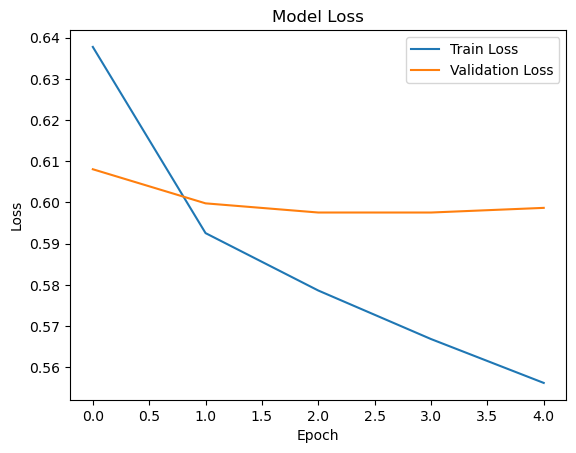

In [6]:
# Initialize the model and move it to GPU
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert training and validation data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train, dtype=torch.int64).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.int64).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Create DataLoader for training and validation
batch_size = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move batch to GPU
            outputs = model(x_batch).squeeze()
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item()
    
    # Calculate average validation loss for the epoch
    val_losses.append(epoch_val_loss / len(val_loader))
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 6. 推荐结果描述

1. **用户选择**：
   - 随机选择一个用户（`user_id`），并获取该用户已观看的电影列表。

2. **未观看电影筛选**：
   - 从电影数据集中筛选出该用户未观看的电影。
   - 过滤掉未在编码映射中的电影，确保数据一致性。

3. **数据准备**：
   - 对未观看的电影和用户 ID 进行编码。
   - 构建用户-电影对数组，用于模型预测。

4. **评分预测**：
   - 使用训练好的模型预测用户对未观看电影的评分。
   - 获取评分最高的 10 部电影作为推荐结果。

5. **结果展示**：
   - 输出用户已观看电影中评分最高的 5 部电影。
   - 输出模型推荐的 10 部电影及其类型。

**总结**：通过模型预测用户对未观看电影的评分，生成个性化推荐列表，帮助用户发现可能感兴趣的电影。

In [7]:
# Load movie data
movie_df = pd.read_csv(movielens_dir / 'movies.csv')

# Select a random user
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]

# Find movies not watched by the user
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

# Filter movies that are in the encoded mapping
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

# Encode the movie IDs
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

# Encode the user ID
user_encoder = user2user_encoded.get(user_id)

# Create user-movie array for prediction
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

# Convert to PyTorch tensor and move to GPU
user_movie_tensor = torch.tensor(user_movie_array, dtype=torch.int64).to(device)

# Predict ratings
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    ratings = model(user_movie_tensor).cpu().numpy().flatten()

# Get top 10 recommended movie IDs
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

# Print recommendations
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 39
Movies with high ratings from user
--------------------------------
Aliens (1986) : Action|Adventure|Horror|Sci-Fi
Go (1999) : Comedy|Crime
Ghost Dog: The Way of the Samurai (1999) : Crime|Drama
Dog Day Afternoon (1975) : Crime|Drama
High Fidelity (2000) : Comedy|Drama|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Grand Day Out with Wallace and Gromit, A (1989) : Adventure|Animation|Children|Comedy|Sci-Fi
American History X (1998) : Crime|Drama
Celebration, The (Festen) (1998) : Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Inside Job (2010) : Documentary
Band of Brothers (2001) : Action|Drama|War
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


## 7. 尝试改进模型提升效果


1. **模型改进**：
   - 在原有矩阵分解模型的基础上，增加了全连接层（`fc1`, `fc2`, `fc3`），以捕捉用户和电影之间更复杂的交互关系。
   - 引入 **Dropout** 和 **Batch Normalization**，防止过拟合并加速训练。
   - 使用 **ReLU** 激活函数增强非线性表达能力。

2. **损失函数与优化器**：
   - 损失函数仍为二元交叉熵（`nn.BCELoss`），适用于归一化后的评分预测。
   - 使用 **AdamW** 优化器，并加入 L2 正则化（`weight_decay=1e-5`），进一步控制模型复杂度。

3. **学习率调度**：
   - 使用 **ReduceLROnPlateau** 调度器，根据验证损失动态调整学习率，避免陷入局部最优。

4. **训练与验证**：
   - 训练过程中记录每个 epoch 的训练损失和验证损失。
   - 通过损失曲线观察模型收敛情况，确保训练稳定。


In [8]:
import torch.nn.functional as F

class ImprovedRecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size, hidden_size=128, dropout_rate=0.2):
        super(ImprovedRecommenderNet, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # User embeddings and bias
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.user_bias = nn.Embedding(num_users, 1)
        
        # Movie embeddings and bias
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.movie_bias = nn.Embedding(num_movies, 1)
        
        # Hidden layers
        self.fc1 = nn.Linear(embedding_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        # Initialize embeddings with normal distribution
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.movie_embedding.weight, std=0.01)
        # Initialize biases with zeros
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)
        # Initialize linear layers with Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, inputs):
        user_indices = inputs[:, 0]
        movie_indices = inputs[:, 1]
        
        # Get embeddings and biases
        user_vector = self.user_embedding(user_indices)
        user_bias = self.user_bias(user_indices).squeeze()
        movie_vector = self.movie_embedding(movie_indices)
        movie_bias = self.movie_bias(movie_indices).squeeze()
        
        # Concatenate user and movie embeddings
        combined = torch.cat([user_vector, movie_vector], dim=1)
        
        # Pass through hidden layers with ReLU activation and batch normalization
        x = F.relu(self.bn1(self.fc1(combined)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x).squeeze()
        
        # Add biases
        x = x + user_bias + movie_bias
        
        # Sigmoid activation to force ratings between 0 and 1
        return torch.sigmoid(x)

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10, Train Loss: 0.646038791860949, Val Loss: 0.6071022635773767
Epoch 2/10, Train Loss: 0.5991628391954559, Val Loss: 0.6015281575390056
Epoch 3/10, Train Loss: 0.5927728880275625, Val Loss: 0.6005966938749144
Epoch 4/10, Train Loss: 0.5897230571096471, Val Loss: 0.599971557719798
Epoch 5/10, Train Loss: 0.5871341876233751, Val Loss: 0.600104155419748
Epoch 6/10, Train Loss: 0.5848866846564794, Val Loss: 0.5999406553521941
Epoch 7/10, Train Loss: 0.5824249799564292, Val Loss: 0.6006839098055151
Epoch 8/10, Train Loss: 0.5754275771727515, Val Loss: 0.6016108495525166
Epoch 9/10, Train Loss: 0.5739082224110118, Val Loss: 0.601642050320589
Epoch 10/10, Train Loss: 0.5725827346567711, Val Loss: 0.60229757654516


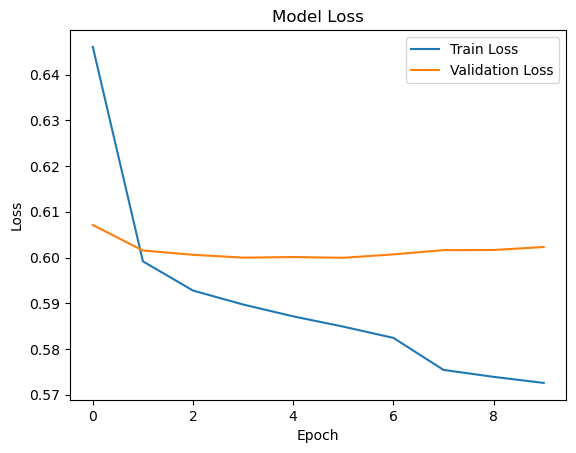

In [12]:
EMBEDDING_SIZE = 128

# Initialize the improved model
model = ImprovedRecommenderNet(num_users, num_movies, EMBEDDING_SIZE, hidden_size=128, dropout_rate=0.5).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # AdamW with L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch).squeeze()
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item()
    
    # Calculate average validation loss for the epoch
    val_losses.append(epoch_val_loss / len(val_loader))
    
    # Adjust learning rate based on validation loss
    scheduler.step(val_losses[-1])
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 7. 结论

### 模型优化效果分析
在本次实验中，我们尝试通过增加模型的复杂性（如引入全连接层、Dropout、Batch Normalization 等）来提升推荐系统的性能。然而，实验结果表明，直接增加模型复杂性的效果并不明显。具体表现如下：
1. **训练损失与验证损失的收敛性**：
   - 训练损失和验证损失在增加模型复杂性后并未显著下降，甚至在部分 epoch 中出现波动。
   - 这表明模型可能并未从额外的复杂性中受益，反而可能引入了过拟合的风险。
2. **推荐效果**：
   - 尽管模型复杂性增加，但推荐结果的质量（如推荐的多样性和准确性）并未显著提升。
   - 这可能是因为 MovieLens 数据集的用户-电影交互模式相对简单，复杂的模型未能捕捉到更多有用的信息。

### 项目总结
本次项目基于 MovieLens 数据集，实现了一个电影推荐系统，并尝试通过多种方法优化模型性能。以下是项目的主要内容和总结：

1. **数据预处理**：
   - 对用户评分数据进行归一化处理，并将其划分为训练集和验证集。
   - 使用 PyTorch 的 `DataLoader` 实现批量数据加载，提升训练效率。

2. **基础模型**：
   - 实现了一个基于矩阵分解的推荐模型，通过用户和电影的嵌入向量预测评分。
   - 模型简单高效，适合处理稀疏数据。

3. **模型优化**：
   - 尝试增加模型的复杂性，包括引入全连接层、Dropout 和 Batch Normalization。
   - 使用 AdamW 优化器和动态学习率调度器，进一步提升训练效果。

4. **训练与验证**：
   - 通过训练损失和验证损失监控模型的收敛情况。
   - 绘制损失曲线，直观展示模型的训练过程。

5. **推荐结果**：
   - 基于模型预测评分，为用户生成个性化电影推荐列表。
   - 展示用户已观看的高评分电影和模型推荐的电影，验证推荐效果。

### 改进方向
尽管本次实验取得了一定的成果，但仍有一些改进空间：
1. **特征工程**：
   - 引入更多上下文信息（如用户年龄、性别、电影类型等），丰富模型的输入特征。
2. **模型选择**：
   - 尝试其他推荐算法，如神经协同过滤（NCF）、基于图的推荐算法（如 GraphSAGE）或 Transformer 模型。
3. **超参数调优**：
   - 对模型的超参数（如嵌入维度、隐藏层大小、Dropout 率等）进行系统调优，找到最佳配置。
4. **评估指标**：
   - 除了 RMSE 和 MAE，还可以引入更多推荐系统特有的评估指标（如 Precision@K、Recall@K、NDCG 等）。

### 总结
本次项目通过实现和优化推荐模型，深入理解了推荐系统的基本原理和实现方法。尽管直接增加模型复杂性的效果有限，但通过进一步的特征工程、模型选择和超参数调优，仍有很大的提升空间。推荐系统是一个复杂且有趣的领域，未来可以继续探索更先进的算法和技术，以提升推荐效果和用户体验。